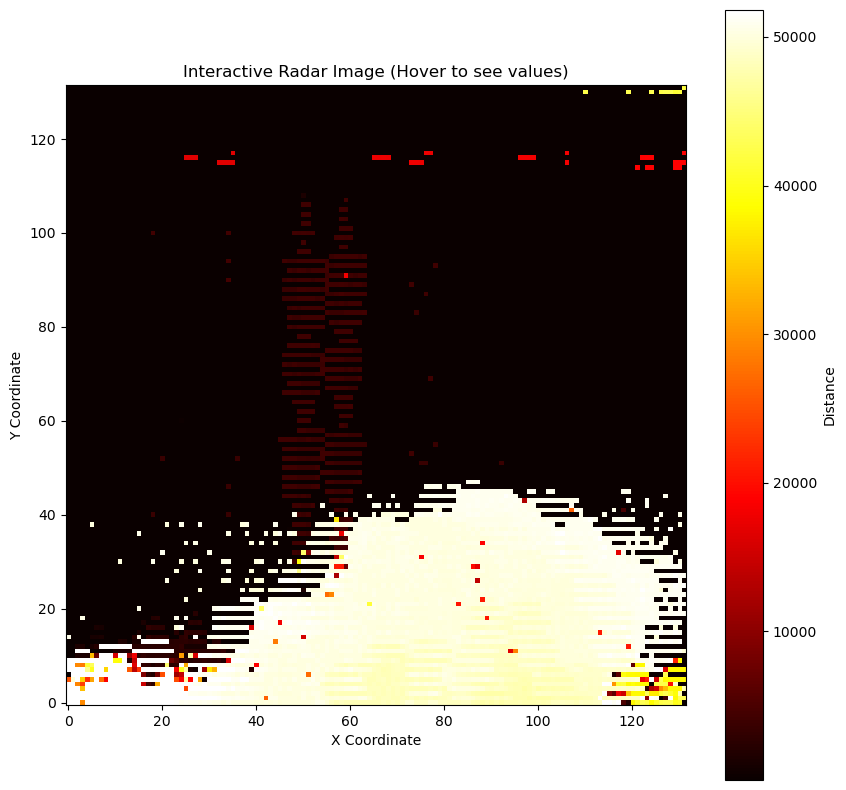

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import mplcursors  # 用于添加数据光标

class RadarImageProcessor:
    def __init__(self, resolution=(132, 132)):
        """
        初始化雷达图像处理器
        :param resolution: 雷达图像分辨率 (width, height)
        """
        self.resolution = resolution
        self.radar_image = np.zeros(resolution[::-1], dtype=np.float32)  # 创建height×width的矩阵
    
    @staticmethod
    def parse_distance(byte4, byte5):
        """将第4和第5字节组合成距离值（小端格式）"""
        return (byte5 << 8) | byte4
    
    def read_radar_data(self, filepath):
        """
        读取雷达数据文件
        :param filepath: 数据文件路径
        :return: 数据列表，每个元素为(y, x, distance)
        """
        data = []
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                    
                try:
                    # 注意：第二列是y，第三列是x
                    y = int(parts[1], 16)
                    x = int(parts[2], 16)
                    byte4 = int(parts[3], 16)
                    byte5 = int(parts[4], 16)
                    distance = self.parse_distance(byte4, byte5)
                    
                    # 过滤超出分辨率的数据
                    if 0 <= x < self.resolution[0] and 0 <= y < self.resolution[1]:
                        # 调整y坐标方向（上下翻转）
                        adjusted_y = self.resolution[1] - 1 - y
                        data.append((adjusted_y, x, distance))
                except ValueError:
                    continue
        return data
    
    def update_image(self, data):
        """
        用新数据更新雷达图像
        :param data: 数据列表，每个元素为(adjusted_y, x, distance)
        """
        for y, x, distance in data:
            self.radar_image[y, x] = distance
    
    def process_files(self, full_scan_file, update_files=None):
        """
        处理雷达数据文件
        :param full_scan_file: 完整扫描文件路径
        :param update_files: 更新文件路径列表
        """
        # 处理完整扫描文件
        full_data = self.read_radar_data(full_scan_file)
        self.update_image(full_data)
        
        # 处理更新文件
        if update_files:
            for file in update_files:
                update_data = self.read_radar_data(file)
                self.update_image(update_data)
    
    def show_interactive_image(self, cmap='hot', vmin=None, vmax=None):
        """
        显示交互式雷达图像（支持鼠标悬停查看数值）
        :param cmap: 颜色映射
        :param vmin/vmax: 颜色范围缩放
        """
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # 左右翻转图像（镜像）
        flipped_image = np.fliplr(self.radar_image)
        
        # 自动确定颜色范围（排除0值）
        non_zero_values = flipped_image[flipped_image > 0]
        if len(non_zero_values) > 0:
            data_min = np.min(non_zero_values)
            data_max = np.max(non_zero_values)
            if vmin is None:
                vmin = data_min
            if vmax is None:
                vmax = data_max * 0.8  # 稍微压缩上限增强对比度
        
        # 绘制图像
        img = ax.imshow(flipped_image, cmap=cmap, origin='lower',
                       vmin=vmin, vmax=vmax)
        plt.colorbar(img, label='Distance')
        ax.set_title('Interactive Radar Image (Hover to see values)')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        
        # 添加交互式光标
        cursor = mplcursors.cursor(img, hover=True)
        
        # 格式化光标提示文本
        @cursor.connect("add")
        def on_add(sel):
            x, y = int(sel.target[0]), int(sel.target[1])
            # 获取原始坐标（考虑过翻转）
            orig_x = self.resolution[0] - 1 - x
            orig_y = self.resolution[1] - 1 - y
            distance = flipped_image[y, x]
            sel.annotation.set(text=f"X: {orig_x}\nY: {orig_y}\nDistance: {distance:.1f}",
                             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.9))
            sel.annotation.get_bbox_patch().set_edgecolor('black')
        
        plt.show()
    
    def save_image(self, output_path=None, filename="radar_image.png", 
                  cmap='hot', vmin=None, vmax=None, dpi=150):
        """
        保存雷达图像（静态图像，无交互功能）
        """
        if output_path is None:
            output_path = os.getcwd()
        
        os.makedirs(output_path, exist_ok=True)
        output_file = os.path.join(output_path, filename)
        
        plt.figure(figsize=(10, 10))
        flipped_image = np.fliplr(self.radar_image)
        
        # 自动确定颜色范围
        non_zero_values = flipped_image[flipped_image > 0]
        if len(non_zero_values) > 0:
            data_min = np.min(non_zero_values)
            data_max = np.max(non_zero_values)
            if vmin is None:
                vmin = data_min
            if vmax is None:
                vmax = data_max * 0.8
        
        img = plt.imshow(flipped_image, cmap=cmap, origin='lower',
                        vmin=vmin, vmax=vmax)
        plt.colorbar(img, label='Distance')
        plt.title('Radar Image')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        
        plt.savefig(output_file, dpi=dpi, bbox_inches='tight')
        plt.close()
        print(f"Radar image saved to {output_file}")
        return output_file


# 使用示例
if __name__ == "__main__":
    # 文件路径配置
    data_dir = r"D:\codes\object_tracking\data\600m"
    full_scan_file = os.path.join(data_dir, "valid_framedata_0113_1.txt")
    update_files = [
        os.path.join(data_dir, "valid_framedata_0113_2.txt"),
        os.path.join(data_dir, "valid_framedata_0113_3.txt"),
        os.path.join(data_dir, "valid_framedata_0113_4.txt"),
        os.path.join(data_dir, "valid_framedata_0113_5.txt"),
        os.path.join(data_dir, "valid_framedata_0113_6.txt"),
    ]
    
    # 创建处理器实例
    processor = RadarImageProcessor(resolution=(132, 132))
    
    # 处理文件
    processor.process_files(full_scan_file, update_files)
    
    # 显示交互式图像（带鼠标悬停功能）
    processor.show_interactive_image(
        cmap='hot',  # 使用高对比度的颜色映射
        vmin=None,   # 自动确定最小值
        vmax=None    # 自动确定最大值（会乘以0.8增强对比度）
    )
    
    # 也可以保存静态图像（可选）
    # processor.save_image(output_path=data_dir, filename="radar_image.png")